In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.express as px
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.combine import SMOTETomek
import shap 
pd.set_option('display.max_columns',30)
import time

# from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from interpret.blackbox import LimeTabular
from interpret import show

# # %% Load and preprocess data
# data_loader = DataLoader()
# data_loader.load_dataset()
# data_loader.preprocess_data()

C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train = pd.read_csv('Cleaned_data/Train_dataset.csv', index_col=0)
test = pd.read_csv('Cleaned_data/Test_dataset.csv', index_col=0)
#test = pd.read_csv('Cleaned_data/New_test_dataset.csv', index_col=0)

In [3]:
train.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail','capacity_bytes'], inplace=True)
test.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail','new_date','capacity_bytes'], inplace=True)
train.head()
train['failure_actual_fail'].value_counts()

0    31277
1      836
Name: failure_actual_fail, dtype: int64

In [4]:
train_features = train.drop(columns=['failure_actual_fail'])
train_y = train[['failure_actual_fail']]
test_features = test.drop(columns=['failure_actual_fail'])
test_y = test[['failure_actual_fail']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_y, test_size=0.3, random_state = 1)
X_test, test_features, y_test, test_y =  train_test_split(X_test, y_test, test_size=0.5, random_state = 1)

In [6]:
from sklearn.metrics import recall_score
def FNR_calc(mat):
    tn = mat[0,0]
    tp = mat[1,1]
    fn = mat[1,0]
    fp = mat[0,1]
    print(f'tn: {tn}, fp: {fp},\nfn: {fn},   tp: {tp}')
    print(f'FNR: {round(fn/(fn+tp) * 100, 2)}%')
    print(f'Recall: {round(tp/(fn+tp) * 100, 2)}%')
    print(f'Precision: {round(tp/(fp+tp) * 100, 2)}%')
    return fn/(fn+tp)

def matrix_plotter(mat):
    ax = sns.heatmap(mat, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hard disk Failure')
    ax.set_xlabel('Predicted Fail')
    ax.set_ylabel('Actual Fail')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

tn: 4599, fp: 74,
fn: 49,   tp: 95
FNR: 34.03%
Recall: 65.97%
Precision: 56.21%


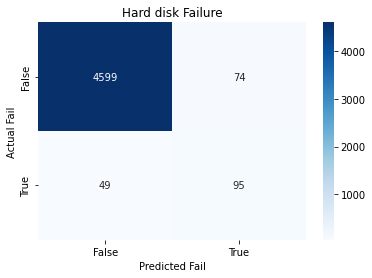

In [7]:
basicOS = RandomOverSampler(sampling_strategy=0.5, random_state = 2331) #can set the proportion of minority/total 
under = RandomUnderSampler(sampling_strategy=1, random_state=2338)
X_over, y_over = basicOS.fit_resample(X_train, y_train)
train_basicOS, label_basicOS = under.fit_resample(X_over,y_over)

xgbc = XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

In [8]:
test_features.reset_index(inplace=True, drop=True)
test_y.reset_index(inplace=True, drop=True)

In [9]:
points = test_features[test_y['failure_actual_fail']==1]

In [10]:
points_y = test_y[test_y['failure_actual_fail']==1]

In [11]:
lime = LimeTabular(predict_fn=xgbc.predict_proba, 
                   data=train_basicOS, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(points[1:10], 
                                points_y[1:10], 
                                name='LIME')

In [12]:
show(lime_local)

<!-- http://127.0.0.1:7001/2920844677424/ -->

In [13]:
lime_local_2 = lime.explain_local(points[50:70], 
                                points_y[50:70], 
                                name='LIME')

In [14]:
show(lime_local_2)

<!-- http://127.0.0.1:7001/2920883598288/ -->

In [15]:
lime_local_2 = lime.explain_local(test_features[1:5], 
                                test_y[1:5], 
                                name='LIME')

In [16]:
show(lime_local_2)

<!-- http://127.0.0.1:7001/2920844537520/ -->